Tables from: https://archive.ics.uci.edu/dataset/186/wine+quality  (09/07/2023) \
winequality-red.csv, observations: 1.599  \
winequality-white.csv, observations: 4.898 

Columns:
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- quality

"quality" will be dropped because it is not based on physicochemical tests. It is based on sensory data.

There are 1177 duplicated observations. After removing duplicated values, we have:
- white: 3961
- red: 1359

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import lightgbm as lgb

import tensorflow as tf
import keras
from keras import models
from keras import layers

In [97]:
df_red = pd.read_csv('winequality-red.csv', sep = ";")
df_white = pd.read_csv('winequality-white.csv', sep = ";")

# Add wine type
df_red['type'] = 0
df_white['type'] = 1

# Join tables
df = pd.concat([df_red, df_white])
# Drop quality
df.drop('quality', axis = 1, inplace = True)
# Remove duplicates
df = df[~df.duplicated()]
# Shuffle data
df = df.sample(frac = 1).reset_index(drop = True)
# Define type as category
df.loc[:,'type'] = df['type'].astype('category')

# log-transform all entries (in case of citric acid you may want to add 1 prior to the transformation)
for col in df.columns[:-1]:
    if col == 'citric acid':
        df[col] = np.log1p(df[col])
    else:
        df[col] = np.log(df[col])


display(df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,1.871802,-0.891598,0.494696,2.468100,-2.733368,4.174387,5.416100,-0.002202,1.137833,-0.673345,2.186051,1
1,1.871802,-2.162823,0.254642,0.667829,-3.270169,4.290459,5.111988,-0.011061,1.137833,-1.386294,2.557227,1
2,1.824549,-1.309333,0.277632,1.840550,-3.036554,3.850148,5.068904,-0.007206,1.166271,-0.510826,2.397895,1
3,1.774952,-0.733969,0.262364,0.405465,-3.296837,2.944439,4.356709,-0.009475,1.244155,-0.867501,2.476538,1
4,2.240710,-1.427116,0.254642,2.140066,-3.296837,4.820282,5.337538,-0.006068,1.064711,-0.967584,2.397895,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5315,2.054124,-1.469676,0.246860,1.558145,-3.170086,3.806662,5.111988,-0.007226,1.085189,-0.916291,2.442347,1
5316,1.916923,-0.210721,0.048790,0.693147,-2.659260,1.791759,2.639057,-0.004390,1.255616,-0.415515,2.379546,0
5317,1.902108,-0.867501,0.329304,2.493205,-3.218876,4.110874,5.513429,-0.002062,1.196948,-0.544727,2.272126,1
5318,1.887070,-1.386294,0.329304,0.371564,-3.218876,3.688879,4.488636,-0.008940,1.208960,-0.916291,2.433613,1


In [98]:
# Split train, validation and test
df_train, df_test = train_test_split(df, test_size = 0.10, random_state = 1, shuffle = True, stratify = df["type"])
df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

print(f'Train observations: {len(df_train)}')
print(f'Test observations: {len(df_test)}')

# scale the attributes. Not necessary for LightGBM, but essential for autoencoder. 
scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train.iloc[:,:-1]), columns = df_train.iloc[:,:-1].columns)
df_train_scaled['type'] = df_train['type']
df_test_scaled = pd.DataFrame(scaler.transform(df_test.iloc[:,:-1]), columns = df_test.iloc[:,:-1].columns)
df_test_scaled['type'] = df_test['type'] 

Train observations: 4788
Test observations: 532


## Creates dataframes with missing values

In [99]:
# Creates dataframes with missing values
def make_missing_values(df):
    # Set missing values for all columns but alcohol
    df_dict = {}
    missing_percent = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
    for e in missing_percent:
        missing_mask = np.random.binomial(1, 1 - e, df.shape)
        missing_mask[:,-1] = 1  # We don't want missing values in the alcohol columns
        df_dict[e] = df * missing_mask
        df_dict[e] = df_dict[e].replace(0, np.nan)
    return df_dict

X_train = df_train_scaled.iloc[:,:-1].copy()
# Set missing values for all columns but alcohol
X_train_missing = make_missing_values(X_train.copy())
y_train = df_train['type']

X_test = df_test_scaled.iloc[:,:-1].copy()
# Set missing values for all columns but alcohol
X_test_missing = make_missing_values(X_test.copy())
y_test = df_test['type']

In [69]:
def bootstrap_sample(X_var, y_var, X_var_full, random_state):
    # Make bootstrap and separate data into X_train, y_train, X_val, y_val
    X_var_bootstrap = X_var.sample(len(X_var), replace = True, random_state = random_state).copy()
    y_train_bootstrap = y_var[X_var_bootstrap.index].copy()
    X_var_full = X_var_full.iloc[X_var_bootstrap.index.to_list()]
    return X_var_bootstrap, y_train_bootstrap, X_var_full

In [100]:
# Model LightGBM
# White = 1
model = lgb.LGBMClassifier
hyperparameters_dict = {"objective": "binary",
            "metric": "binary_logloss",
            "boosting_type": "gbdt",
            'verbose': -1,
            'seed': 1,
            "num_iterations": 50,
            "min_data_in_leaf": 10,
            "max_depth": 4,
            "feature_fraction": 0.45,
            "learning_rate": 0.05}  

n_bootstrap = 10
list_accuracy_lgbm_train = []
list_accuracy_lgbm_test = []
list_accuracy_with_autoencoder_train = []
list_accuracy_with_autoencoder_test = []
missing_percent = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
for e in missing_percent:
    list_accuracy_lgbm_bootstrap_train = []
    list_accuracy_lgbm_bootstrap_test = []
    list_accuracy_with_autoencoder_bootstrap_train = []
    list_accuracy_with_autoencoder_bootstrap_test = []
    for boots_i in range(n_bootstrap):
        # Train with bootstrap
        X_train_bootstrap, y_train_bootstrap, X_train_full_bootstrap = bootstrap_sample(X_var = X_train_missing[e].copy(), y_var = y_train.copy()
                                                                                        , X_var_full = X_train.copy(), random_state = boots_i)
        
        # Input median for missing values
        X_train_aux = X_train_bootstrap.copy()
        median = X_train_aux.median()
        X_train_aux = X_train_aux.fillna(median)

        X_test_aux = X_test_missing[e].copy()
        X_test_aux = X_test_aux.fillna(median)
    
        # Fit model LightGBM
        lightgbm_aux_fit = lgb.LGBMClassifier(**hyperparameters_dict).fit(X_train_aux, y_train_bootstrap)
        # Predict LightGBM
        y_pred_prob_train_aux = lightgbm_aux_fit.predict_proba(X_train_aux)[:,1]
        y_pred_train_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_train_aux]
        
        y_pred_prob_test_aux = lightgbm_aux_fit.predict_proba(X_test_aux)[:,1]
        y_pred_test_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_test_aux]

        # Append results bootstrap LightGBM
        list_accuracy_lgbm_bootstrap_train.append(accuracy_score(y_train_bootstrap, y_pred_train_aux))
        list_accuracy_lgbm_bootstrap_test.append(accuracy_score(y_test, y_pred_test_aux))

        # Use denoising autoencoder
        tf.keras.backend.clear_session()
        model_encoder = models.Sequential([
            layers.Dense(8, activation = 'selu', input_shape = [11])
        ])
        model_decoder = models.Sequential([
            layers.Dense(11, activation = 'selu', input_shape = [8])
        ])
        model_autoencoder = models.Sequential([model_encoder, model_decoder])   
        model_autoencoder.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.05),
                            loss = 'mse', metrics = ['mse'])
        # Train denoising Autoencoder
        # Input 0 for missing values
        X_train_aux = X_train_bootstrap.copy()
        X_train_aux = X_train_aux.fillna(0)
        
        X_test_aux = X_test_missing[e].copy()
        X_test_aux = X_test_aux.fillna(0)
        
        model_autoencoder.fit(X_train_aux, X_train_full_bootstrap, verbose = 0, epochs = 30)
        # Get the codings
        codings_X_train_aux = model_encoder.predict(X_train_aux)
        X_codings_train_aux = pd.DataFrame(codings_X_train_aux, columns = ['coding_1', 'coding_2', 'coding_3', 'coding_4', 'coding_5', 'coding_6', 'coding_7', 'coding_8'])
        
        codings_X_test_aux = model_encoder.predict(X_test_aux)
        X_codings_test_aux = pd.DataFrame(codings_X_test_aux, columns = ['coding_1', 'coding_2', 'coding_3', 'coding_4', 'coding_5', 'coding_6', 'coding_7', 'coding_8'])

        # LightGBM with autoencoder       
        lightgbm_fit_2_aux = lgb.LGBMClassifier(**hyperparameters_dict).fit(X_codings_train_aux, y_train_bootstrap)
        y_pred_prob_train_2_aux = lightgbm_fit_2_aux.predict_proba(X_codings_train_aux)[:,1]
        y_pred_train_2_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_train_2_aux]
        
        y_pred_prob_test_2_aux = lightgbm_fit_2_aux.predict_proba(X_codings_test_aux)[:,1]
        y_pred_test_2_aux = [1 if x > 0.5 else 0 for x in y_pred_prob_test_2_aux]
        
        # Append results bootstrap LightGBM with autoencoder
        list_accuracy_with_autoencoder_bootstrap_train.append(accuracy_score(y_train_bootstrap, y_pred_train_2_aux))
        list_accuracy_with_autoencoder_bootstrap_test.append(accuracy_score(y_test, y_pred_test_2_aux))

    # Append results after bootstrap
    list_accuracy_lgbm_train.append(list_accuracy_lgbm_bootstrap_train)
    list_accuracy_lgbm_test.append(list_accuracy_lgbm_bootstrap_test)
    list_accuracy_with_autoencoder_train.append(list_accuracy_with_autoencoder_bootstrap_train)
    list_accuracy_with_autoencoder_test.append(list_accuracy_with_autoencoder_bootstrap_test)

C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 3ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 998us/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 944us/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 1ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


17/17 [==============================] - 0s 2ms/step


C:\Users\maxwi\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [101]:
# Collect mean and standard deviation from the performance metrics
list_accuracy_lgbm_test_mean = []
list_accuracy_lgbm_test_std = []
list_accuracy_with_autoencoder_test_mean = []
list_accuracy_with_autoencoder_test_std = []
for i in range(len(list_accuracy_lgbm_test)):
    list_accuracy_lgbm_test_mean.append(np.mean(list_accuracy_lgbm_test[i]))
    list_accuracy_lgbm_test_std.append(np.std(list_accuracy_lgbm_test[i]))
    list_accuracy_with_autoencoder_test_mean.append(np.mean(list_accuracy_with_autoencoder_test[i]))
    list_accuracy_with_autoencoder_test_std.append(np.std(list_accuracy_with_autoencoder_test[i]))

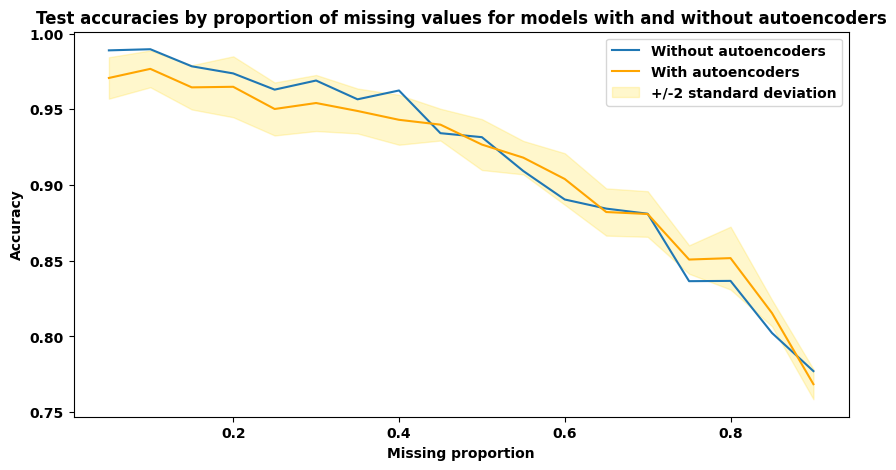

In [103]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(missing_percent, list_accuracy_lgbm_test_mean, label = 'Without autoencoders')
axes.plot(missing_percent, list_accuracy_with_autoencoder_test_mean, color = 'orange', label = 'With autoencoders')
# +/- 2 standard deviation from test
axes.fill_between(missing_percent, list_accuracy_with_autoencoder_test_mean + 2*np.array(list_accuracy_with_autoencoder_test_std)
                  , list_accuracy_with_autoencoder_test_mean - 2*np.array(list_accuracy_with_autoencoder_test_std)
                  , color = 'gold', alpha=0.2, label = '+/-2 standard deviation')
axes.set_xlabel('Missing proportion')
axes.set_ylabel('Accuracy')
axes.set_title("Test accuracies by proportion of missing values for models with and without autoencoders")
axes.legend()

plt.show()
plt.close();